In [430]:
import numpy as np
from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam 

%matplotlib inline


In [431]:
from typing import List

data_dimension = 2

means = torch.Tensor([1.5, 2.5])
variances = torch.Tensor([0.2, 0.15])

def sample_2d_points(mean : torch.Tensor, variance: torch.Tensor, num_samples = 10):
    samples: List[torch.Tensor] = []
    for i in range(num_samples):
        sample =  torch.normal(mean=mean, std=torch.sqrt(variance))
        samples.append(sample)

    return torch.stack(samples,dim=0)

torch.manual_seed(42)


sampled_points = sample_2d_points(means, variances,5)

print(sampled_points)

xs = sampled_points[ : , 0]
ys = sampled_points[ : , 1]

print("X & Y: ", xs, ys)
print("Horizontal stacking: ", torch.hstack((xs, ys)))
vertical_stack =  torch.vstack( (xs, ys) )
print("Vertical stack: ", vertical_stack)

print("Transposed: ", sampled_points.transpose(0,1))

original = torch.stack([ vertical_stack[ : , i] for i in range(vertical_stack.shape[1]) ])

print("Original recreation: ", original)


tensor([[1.6506, 2.5499],
        [1.6049, 2.5892],
        [0.9978, 2.4278],
        [2.4875, 2.2529],
        [1.7065, 2.6035]])
X & Y:  tensor([1.6506, 1.6049, 0.9978, 2.4875, 1.7065]) tensor([2.5499, 2.5892, 2.4278, 2.2529, 2.6035])
Horizontal stacking:  tensor([1.6506, 1.6049, 0.9978, 2.4875, 1.7065, 2.5499, 2.5892, 2.4278, 2.2529,
        2.6035])
Vertical stack:  tensor([[1.6506, 1.6049, 0.9978, 2.4875, 1.7065],
        [2.5499, 2.5892, 2.4278, 2.2529, 2.6035]])
Transposed:  tensor([[1.6506, 1.6049, 0.9978, 2.4875, 1.7065],
        [2.5499, 2.5892, 2.4278, 2.2529, 2.6035]])
Original recreation:  tensor([[1.6506, 2.5499],
        [1.6049, 2.5892],
        [0.9978, 2.4278],
        [2.4875, 2.2529],
        [1.7065, 2.6035]])


In [432]:
def plot_2d_sample(samples: torch.Tensor):
    samples_np = samples.numpy()
    xs = samples_np[:, 0]
    ys = samples_np[:, 1]
    plt.figure()
    plt.scatter(xs, ys)
    plt.show()

Stack points vertically: 
 tensor([[2.6692, 1.3135],
        [2.8511, 0.3455],
        [2.1873, 1.3710],
        [2.9181, 1.3165],
        [2.2578, 0.7093],
        [6.1049, 7.2170],
        [5.3534, 7.2514],
        [5.6259, 7.0178],
        [5.7338, 6.9246],
        [5.4777, 7.1664]])
Stack points side by side: 
 tensor([[2.6692, 1.3135, 6.1049, 7.2170],
        [2.8511, 0.3455, 5.3534, 7.2514],
        [2.1873, 1.3710, 5.6259, 7.0178],
        [2.9181, 1.3165, 5.7338, 6.9246],
        [2.2578, 0.7093, 5.4777, 7.1664]])


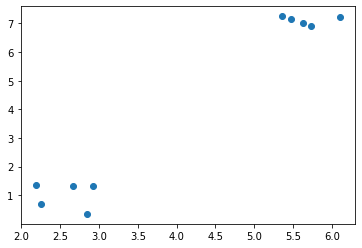

In [433]:
t1 = sample_2d_points( torch.Tensor( (2.5, 1.0)), torch.Tensor( (0.1, 0.15) ) , 5 )
t2 = sample_2d_points( torch.Tensor( (5.5, 7.0)), torch.Tensor( (0.2, 0.1) ) , 5 )

z = torch.cat( (t1,t2), dim= 0)

print("Stack points vertically: \n", torch.cat( (t1,t2), dim= 0))

print("Stack points side by side: \n", torch.cat( (t1,t2), dim= 1))

plot_2d_sample(z)

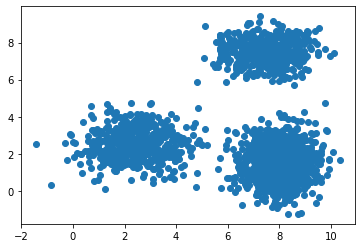

In [434]:
def generate_data_points(reduced:bool = False) -> torch.Tensor:
    # generate some clusters
    sizes = (2,2,2)
    cluster1 = sample_2d_points(
        torch.Tensor([2.5, 2.5]),
        torch.Tensor([1.2, .8]),
        num_samples=500 if not reduced else sizes[0]
    )

    cluster2 = sample_2d_points(
        torch.Tensor([7.5, 7.5]),
        torch.Tensor([.75, .5]),
        num_samples=500 if not reduced else sizes[1]
    )

    cluster3 = sample_2d_points(
        torch.Tensor([8, 1.5]),
        torch.Tensor([.6, .8]),
        num_samples=1000 if not reduced else sizes[2]
    )
    
    points = torch.cat( (cluster1, cluster2, cluster3), dim= 0 )
    return points


points_generated = generate_data_points(reduced=False)
def plot_points():
    plot_2d_sample(points_generated)

plot_points()


In [435]:
def initialize(data: torch.Tensor, num_mixtures, dimension: int, initial_variance = 1):
    # choose num_mixtures points from data without replacement to initialize means
    total_data_points = data.size(0)
    idxs = torch.from_numpy(np.random.choice(total_data_points, num_mixtures, replace=False)).long()

    mixture_means = data[idxs]

    # # uniform sampling for means and variances
    # var = torch.Tensor(num_mixtures, dimension).fill_(initial_variance)

    data_variance = data.var(dim=0).repeat(num_mixtures, 1)
    var = data_variance

    # var_dummy = var * data_variance
    # print(data_variance)
    # print(var)

    # print("Filled variance: ", var_dummy)
    # print( "Repeat: ", )

    # uniform prior
    pi = torch.empty(num_mixtures).fill_(1. / num_mixtures)

    return mixture_means, var, pi

means, variances, priors = initialize(points_generated,num_mixtures=3,dimension= data_dimension)

log_variances = variances.log()

#log_variances, variances

In [436]:
# good gaussian description
# https://brilliant.org/wiki/gaussian-mixture-model/

def compute_gaussian(data: torch.Tensor, means: torch.tensor, log_variances: torch.Tensor) -> torch.Tensor:
        #  p( x| mu, sigma^2) =  (1/sqrt(2*pi*sigma^2))*exp(-0.5*(1/sigma^2)*(x - mu)^2)
        # log(p(x | mu, sigma^2)) => -0.5*log(2*pi) - 0.5 * ( log(sigma^2) +  ( (x - mu)^2/exp(log(sigma^2)) ) )
        a = (data - means)**2

        intermediate = (log_variances +  a / log_variances.exp())
        r1 = -0.5 * np.log( 2*np.pi) 
        r2 = - 0.5 * intermediate
        result = r1 + r2
        return result

def compute_likelihoods(data: torch.Tensor, means: torch.tensor, log_variances: torch.Tensor, log_likelihood=True):
    data_expanded = data[None, :, :] # (1, n , features)

    # k is no of gaussian mixtures
    means_expanded: torch.Tensor = means[ :, None, :]  # (k, 1, features ) transforms into (k, n, features)
    log_variance_expanded = log_variances[: , None, :] # (k, 1, features ) transfroms into (k, n, features)

    # features are broadcasted in means and log_variances during tensor operation
    log_likelihoods = compute_gaussian(data_expanded, means_expanded, log_variance_expanded)

    # sum over the feature dimension
    #log(X1 * X2 * X3 .. * Xn) => sum( log(Xi) )
    log_likelihoods = log_likelihoods.sum(-1) # -1 => last dimension

    if log_likelihood == False:
        return log_likelihoods.exp_()

    return log_likelihoods

def compute_likelihoods2(data: torch.Tensor, means: torch.Tensor, log_variances: torch.Tensor, log_likelihood=True):
    data_expanded = data[None,:,:]
    means_expanded = means[:, None, :]
    log_variances_expanded = log_variances[:, None, :]

    a = (data_expanded - means_expanded)**2
    intermediate = (log_variances_expanded + a/log_variances_expanded.exp())
    final : torch.Tensor = -0.5*np.log(2*np.pi) - 0.5 * intermediate

    return final

def compute_posteriors(log_likelihoods: torch.Tensor, log_priors: torch.Tensor):
    # P(C|X) = P(C,X)/P(X) => P(C) * P(X|C) / Sum_Over_C( P(C) * P(X|C) )
    def compute_logsumexp(a: torch.Tensor, dim = 0, keepdim = True):
        # this will not retain dimention so 
        # later operation like sum, multiply is not possible
        #max_without_dim, _ = torch.max(a, dim=dim, keepdim=False)
        #print(max_without_dim )

        # retain dimension so that future operations(sum, multiply) is possible. 
        max, _ = torch.max(a, dim=dim, keepdim=True)
        
        # print(max)
        # print("*******************************")
        # print("(item - max): \n", (a - max) )
        # print("exp(item - max): \n", (a - max).exp())
        # print("Sum:\n", (a - max).exp().sum(dim=dim,keepdim=keepdim) )
        # print("Log:\n", (a - max).exp().sum(dim=dim).log() )

        # print("no-dim Sum:\n", (a - max).exp().sum(dim=dim, keepdim=True).log().shape)

        #[ 2, 5, 2]
        #  5 * [2/5, 5/5, 2/5]
        # log5 + [log2 - log5, log5 - log5, log2 - log5]
        # log5 + [exp(first), exp(second), exp(third) ]
        # log5 + [exp(first)/sum_exps, exp(second)/sum_exps , exp(third)/sum_exps ]

        out = max + (a - max).exp().sum(dim=dim, keepdim=keepdim).log()
        return out



    # this is assuming same priors. But why??
    posterior =  log_likelihoods #+ log_priors

    lsexp = compute_logsumexp(posterior)
    #print(posterior.shape, lsexp.shape)
    final_posterior = posterior - lsexp
    return final_posterior

log_likelihoods = compute_likelihoods(points_generated, means, log_variances,True)
log_priors = priors.log()

log_posteriors = compute_posteriors(log_likelihoods, log_priors)
    

In [437]:
def get_parameters(data : torch.Tensor, log_posteriors: torch.Tensor, eps=1e-6, minimum_variance=1e-6):
    # priors_k =  sum_1_to_N( posteriors) / N
    posteriors = log_posteriors.exp()
    mixture_size = posteriors.size(0)
    
    n_priors = posteriors.sum(dim=1)
    n_priors = n_priors.view(mixture_size, 1, 1)

    # means_k =  sum_1_to_N( posteriors * x ) / sum_1_to_N ( posteriors)
    means = posteriors[ :, None ] @ data[None, ]
    means = means/ (n_priors + eps)

    # variances_k = sum_1_to_N( posteriors * (x - means)^2 )/ sum_1_to_n( posteriors )
    diff = (data.unsqueeze(0) - means )
    temp = posteriors[:, None, ] @ (diff**2)
    variances = temp/( n_priors + eps )

    log_variances = torch.clamp(variances, min=minimum_variance).log()

    # recompute the mixing probabilities
    priors = n_priors / n_priors.sum() # n_priors.sum() results in total data points but why???
    return means.squeeze(1) , log_variances.squeeze(1),  priors.squeeze()

means, log_variances, priors = get_parameters(points_generated,log_posteriors)


In [438]:
import numpy as np
def get_density(means: torch.Tensor, log_variances: torch.Tensor, priors: torch.Tensor, N=50, X_range=(0, 5), Y_range=(0, 5)):
    """ Get the mesh to compute the density on. """
    X: np.ndarray = np.linspace(*X_range, N)
    Y: np.ndarray = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    points = torch.from_numpy(points).float()
    
    # compute the densities under each mixture
    likelihoods = compute_likelihoods(points, means, log_variances, log_likelihood=False)
    
    # sum the densities to get mixture density
    Z : np.ndarray = torch.sum(likelihoods, dim=0).data.numpy().reshape([N, N])
    
    return X, Y, Z

In [441]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

def plot_density(X: np.ndarray, Y: np.ndarray, Z: np.ndarray, i=0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.inferno)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
#     plt.savefig('fig_{}.png'.format(i), dpi=400, bbox_inches='tight')
    plt.show()

M:  tensor([[2.7575, 3.3984],
        [8.3170, 7.4722],
        [7.3368, 1.8954]])


c:\Users\Dev2\anaconda3\envs\gpu-pytorch\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  if __name__ == '__main__':


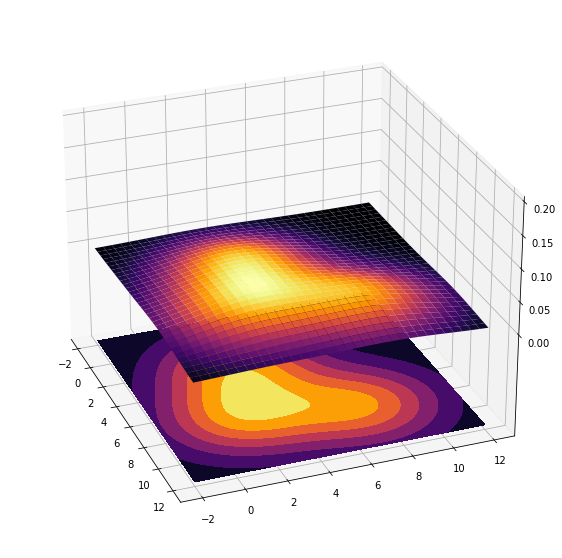

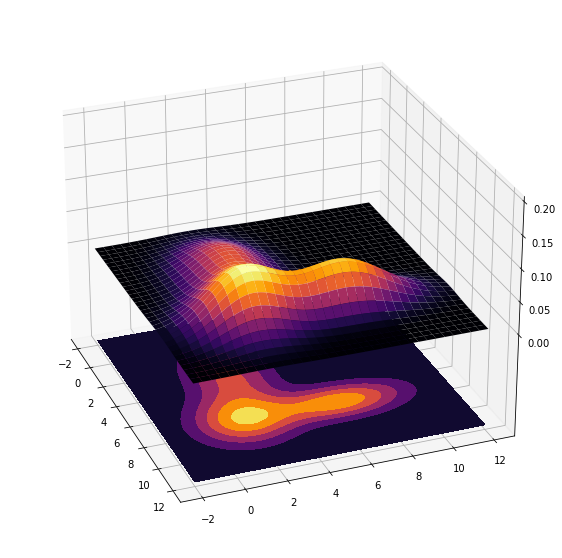

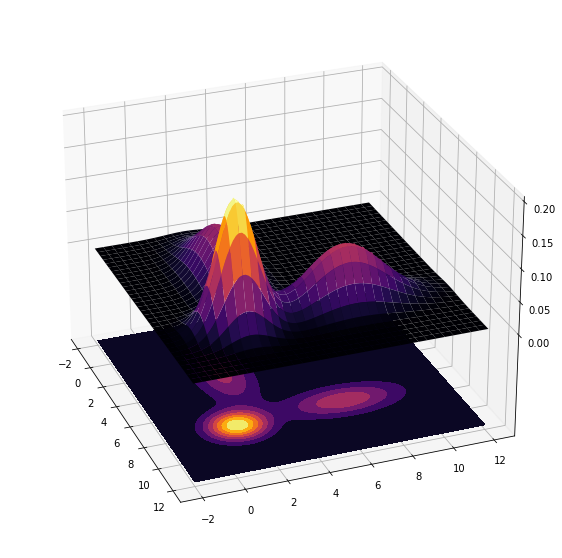

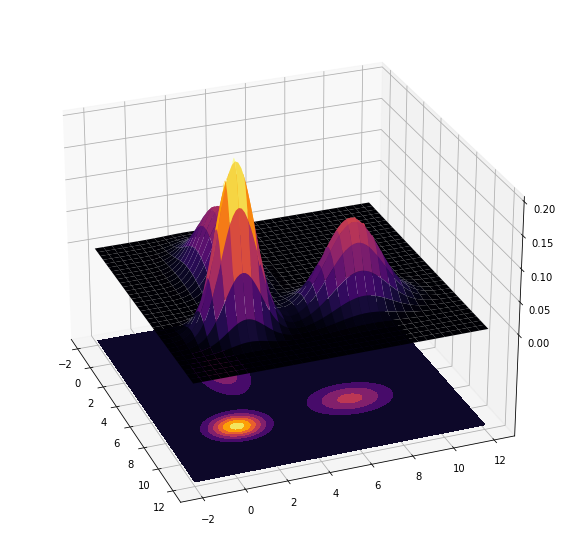

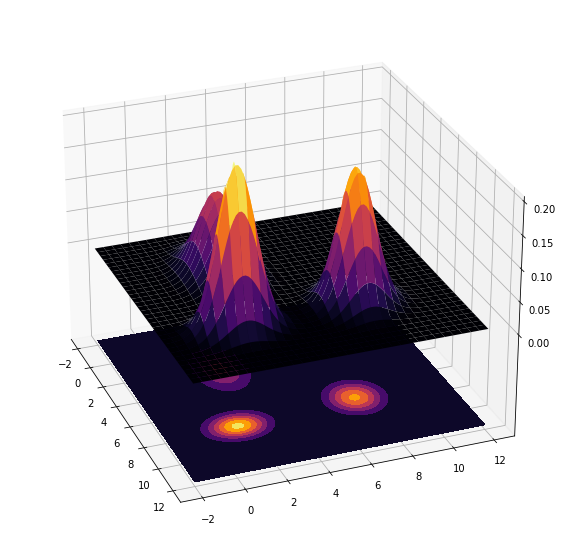

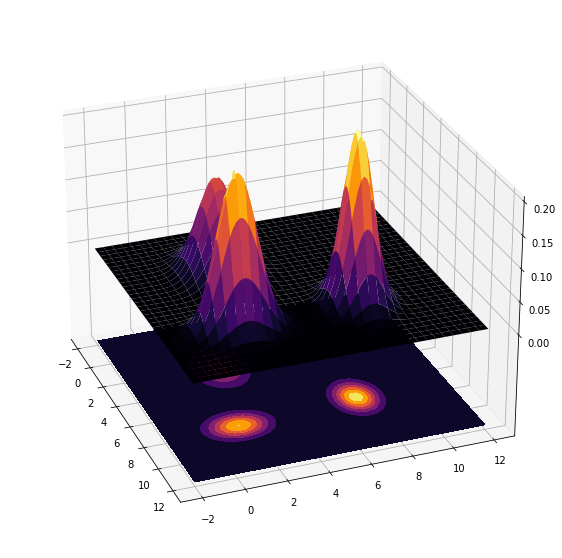

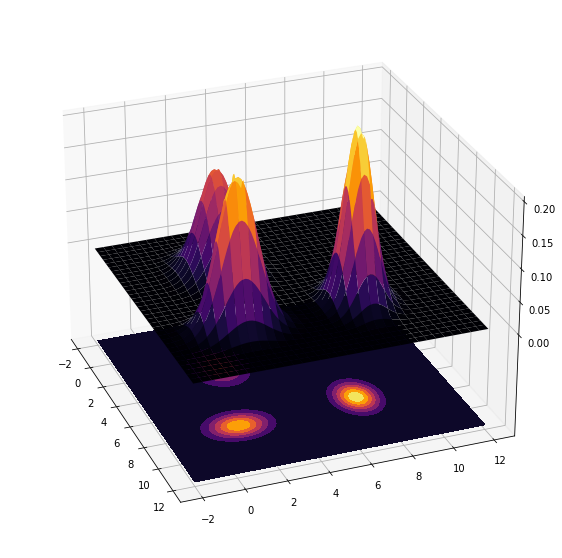

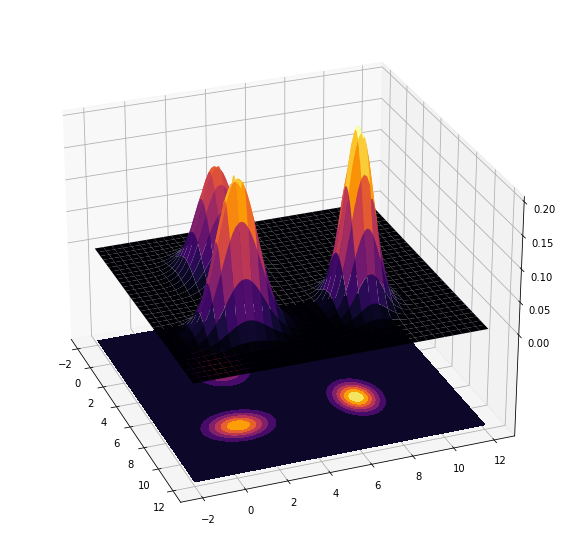

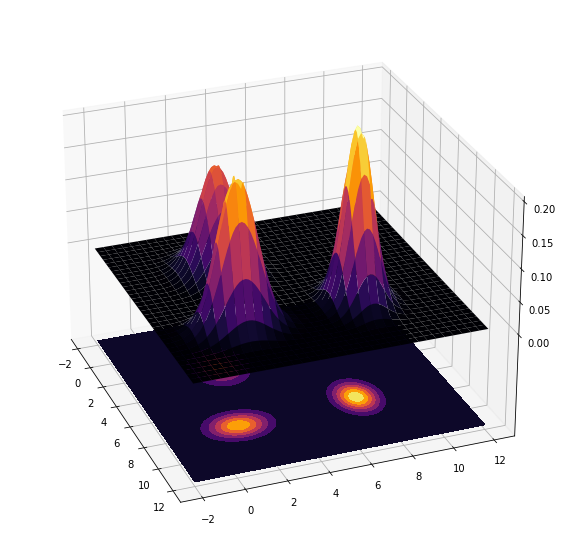

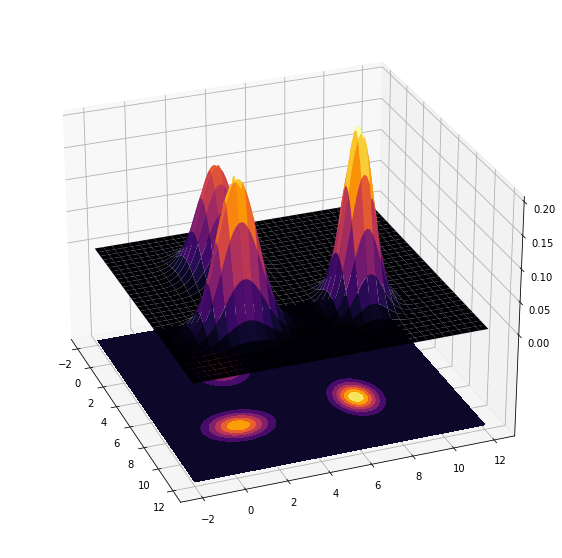

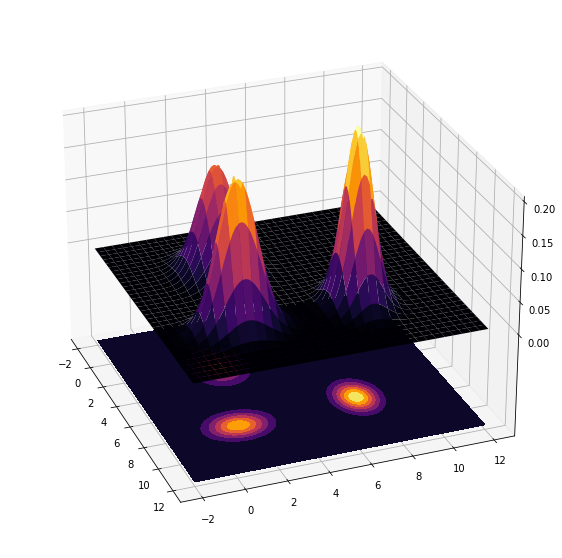

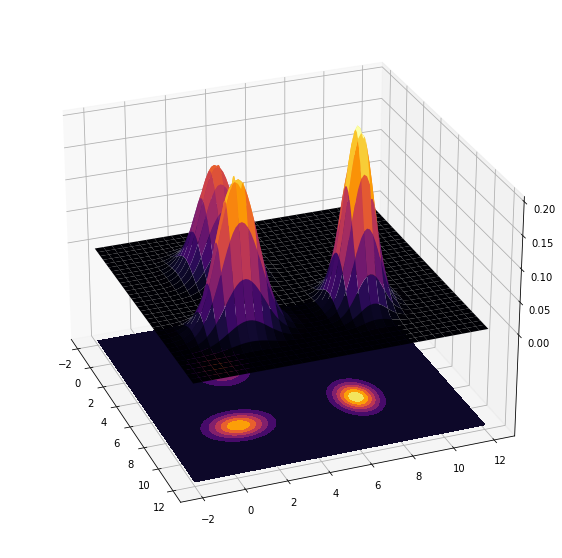

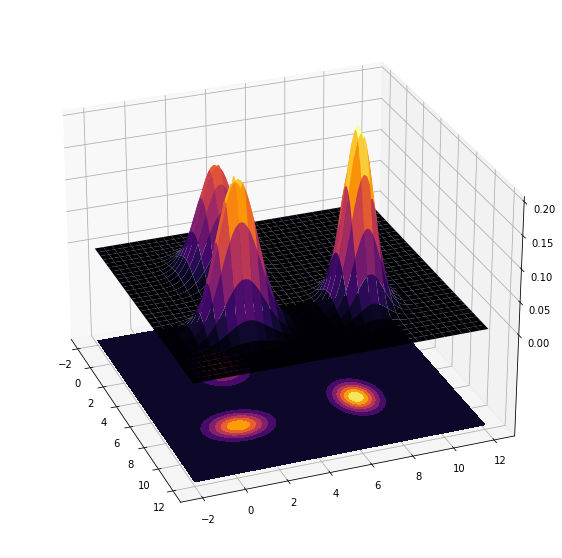

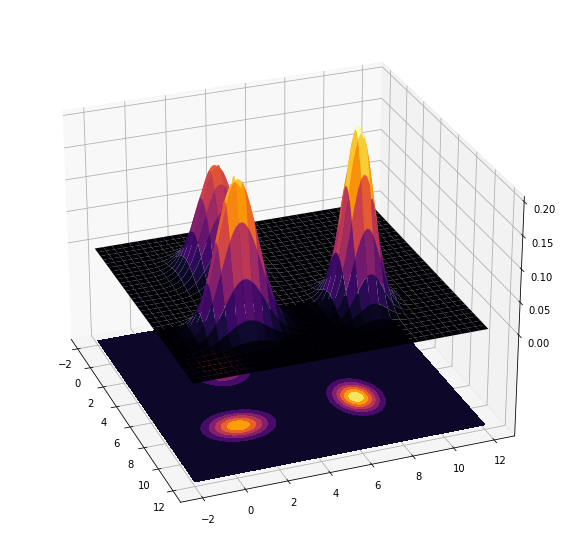

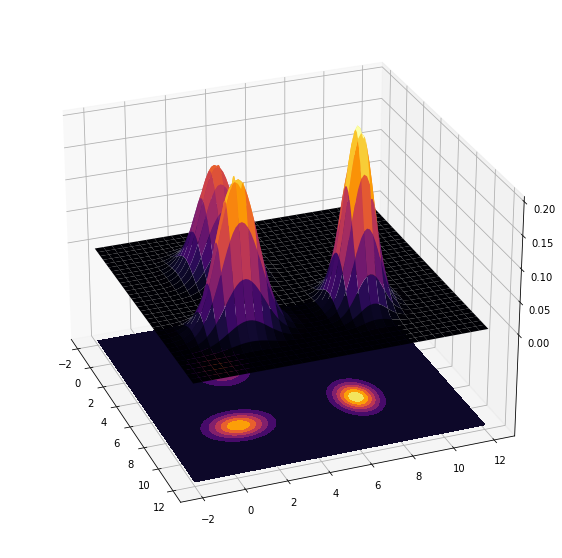

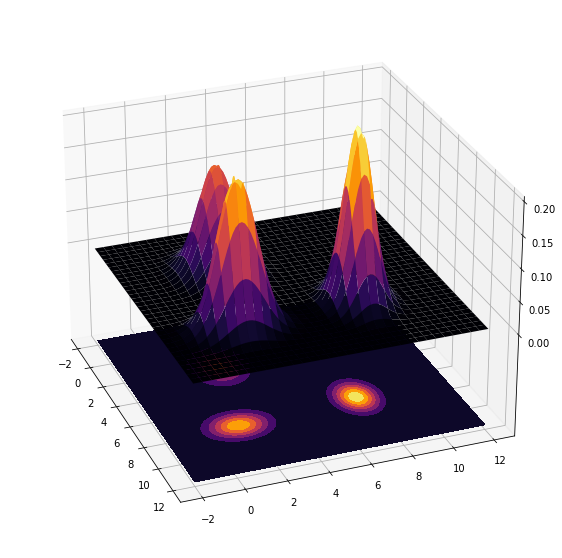

tensor([[2.4988, 2.5235],
        [7.5024, 7.4938],
        [8.0252, 1.5035]]) tensor([[ 0.1987, -0.3201],
        [-0.1967, -0.8582],
        [-0.6153, -0.1410]]) tensor([0.2501, 0.2500, 0.4999])


In [442]:
# training loop
num_mixtures = 3
dimension = 2
num_iterations = 50

data = points_generated
means, variances, priors = initialize(data, num_mixtures, dimension, initial_variance=1)
print("M: ", means)
log_variances = variances.log()

prev_cost = float('inf')
thresh = 1e-5

for i in range(num_iterations):
    # get the likelihoods p(x|z) under the parameters
    log_likelihoods = compute_likelihoods(data, means, log_variances,True)
    
    # plot!
    X,Y,Z = get_density(means, log_variances, priors, N=100, X_range=(-2, 12), Y_range=(-2, 12))
    plot_density(X,Y,Z, i=i)
    
    # compute the "responsibilities" p(z|x)
    log_posteriors = compute_posteriors(log_likelihoods, priors.log())
    
    # compute the cost and check for convergence
    cost = log_likelihoods.mean()
    diff = prev_cost - cost
    if torch.abs(diff).item() < thresh:
        break
    prev_cost = cost
    
    # re-compute parameters
    means, log_variances, priors = get_parameters(data, log_posteriors)

print(means, log_variances, priors)